# DCPA and TCPA Calculation for Ships with Python

DCPA: Distance to Closest Point of Approach

TCPA: Time to Closest Point of Approach

Equations are implemented from Xie, Shuo, et al. (2020) but I have converted them accordingly to be used with Python and radians. To be specific the North is not pointing up but pointing right in Python when you enter ships course as 0 degrees. Additionally angles are calculated in counter clockwise direction.

In [72]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


class Ship:
    '''
        Defining ship objects.
    '''
    def __init__(self, name, x, y, psi, U):
        self.name = name
        self.x = x
        self.y = y
        self.psi = math.radians(psi)
        self.U = U
        self.u = U * math.cos(self.psi)
        self.v = U * math.sin(self.psi)
        self.xt = self.x + (self.u * 10)
        self.yt = self.y + (self.v * 10)
        self.x_cpa = 0.0
        self.y_cpa = 0.0
    
    def cpa(self, targetship):
        '''
            DCPA and TCPA with targetship
        '''
        # Distance between ownship and targetship
        D_r = math.sqrt((targetship.x - self.x)**2 + (targetship.y - self.y)**2)
    
        # Relative speed between ownship and targetship
        U_r = math.sqrt((targetship.u - self.u)**2 + (targetship.v - self.v)**2)
    
        # alpha_r (True bearing of the targetship)
        if (targetship.y - self.y >= 0) and (targetship.x - self.x >= 0):
            delta_alpha = 0
        elif (targetship.y - self.y >= 0) and (targetship.x - self.x < 0):
            delta_alpha = 0
        elif (targetship.y - self.y < 0) and (targetship.x - self.x < 0):
            delta_alpha = 2 * math.pi
        elif (targetship.y - self.y < 0) and (targetship.x - self.x >= 0):
            delta_alpha = 2 * math.pi
        alpha_r = math.atan2((targetship.y - self.y), (targetship.x - self.x)) + delta_alpha
        
        # chi_r (Relative course of TS (from 0 to U_r))
        if (targetship.v - self.v >= 0) and (targetship.u - self.u >= 0):
            delta_chi = 0
        elif (targetship.v - self.v >= 0) and (targetship.u - self.u < 0):
            delta_chi = 0
        elif (targetship.v - self.v < 0) and (targetship.u - self.u < 0):
            delta_chi = 2 * math.pi
        elif (targetship.v - self.v < 0) and (targetship.u - self.u >= 0):
            delta_chi = 2 * math.pi
        chi_r = math.atan2((targetship.v - self.v), (targetship.u - self.u)) + delta_chi
        
        # beta
        beta = chi_r - alpha_r - math.pi 
        
        # DCPA and TCPA
        dcpa = abs(round(D_r * math.sin(beta), 2))
        tcpa = round((D_r * math.cos(beta)) / abs(U_r), 2)
        print("DCPA:", dcpa, " TCPA:", tcpa)
        
        # Collision Risk Index (CRI)
        cons_d = 0.8
        cons_t = 0.2
        d_safe = 1000
        t_safe = 1000
        if dcpa >= 1000 or tcpa >= 1000 or tcpa < 0:
            cri = 0.0
        elif dcpa < 1000:
            cri = 0.001 * (cons_d * (d_safe - dcpa) * cons_t * (t_safe - tcpa))
        print("CRI: ", cri)
        
        return dcpa, tcpa, cri
    

def visualize(ships):
    '''
        Function to visualize the scenario.
    '''
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink']
    
    # ship positions at TCPA
    for ship in ships:
        ship.x_cpa = ship.x + (ship.U * math.cos(ship.psi) * tcpa)
        ship.y_cpa = ship.y + (ship.U * math.sin(ship.psi) * tcpa)

    plt.figure(figsize=(7,7))
    
    for ship, color in zip(ships, colors):
        plt.scatter(ship.x, ship.y, label=ship.name, c=color, s=70)
        plt.plot([ship.x, ship.xt], [ship.y, ship.yt], c=color)
        plt.plot([ship.x, ship.x_cpa], [ship.y, ship.y_cpa], 'k--', alpha=0.3)
        plt.scatter(ship.x_cpa, ship.y_cpa, marker="x", c=color, alpha=0.8)
    
    plt.xlim(-600, 600)
    plt.ylim(-600, 600)
    plt.title("Ship Positions at CPA")
    plt.grid()
    plt.legend()
    plt.show()

## Example 1

DCPA: 110.82  TCPA: 66.81
CRI:  132.76382147200005


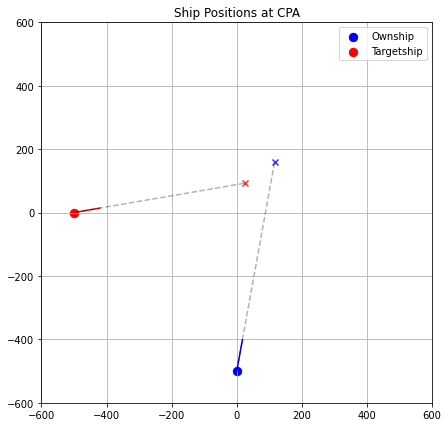

In [73]:
# Creating ship objects
ship1 = Ship("Ownship", 0, -500, 80, 10)
ship2 = Ship("Targetship", -500, 0, 10, 8)
ships = [ship1, ship2]

# Executing the scenario
dcpa, tcpa, cri = ship1.cpa(ship2)
visualize(ships)

## Example 2

DCPA: 311.32  TCPA: 93.73
CRI:  99.86080377600001


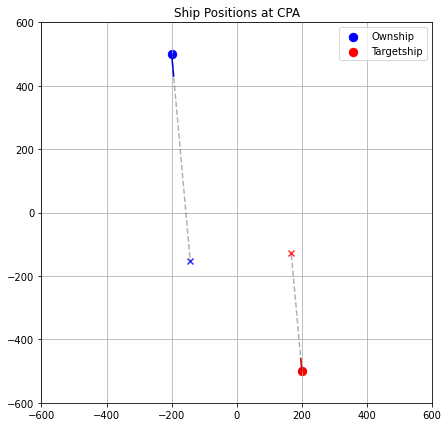

In [97]:
# Creating ship objects
ship1 = Ship("Ownship", -200, 500, 275, 7)
ship2 = Ship("Targetship", 200, -500, 95, 4)
ships = [ship1, ship2]

# Executing the scenario
dcpa, tcpa, cri = ship1.cpa(ship2)
visualize(ships)

## Example 3

DCPA: 1053.27  TCPA: 111.72
CRI:  0.0


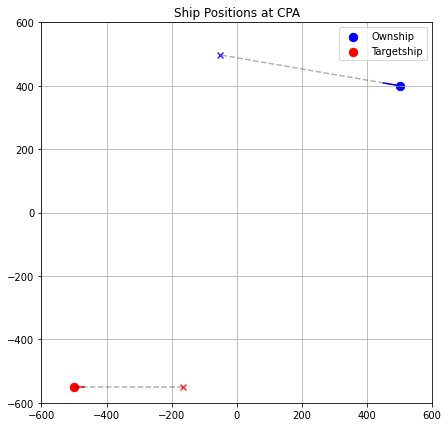

In [91]:
# Creating ship objects
ship1 = Ship("Ownship", 500, 400, 170, 5)
ship2 = Ship("Targetship", -500, -550, 0, 3)
ships = [ship1, ship2]

# Executing the scenario
dcpa, tcpa, cri = ship1.cpa(ship2)
visualize(ships)

## DCPA, TCPA, CRI Visualization

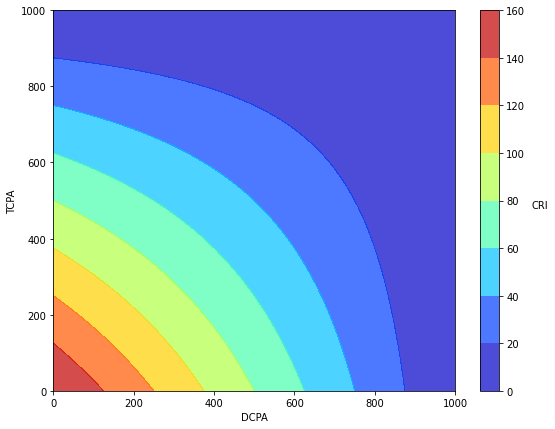

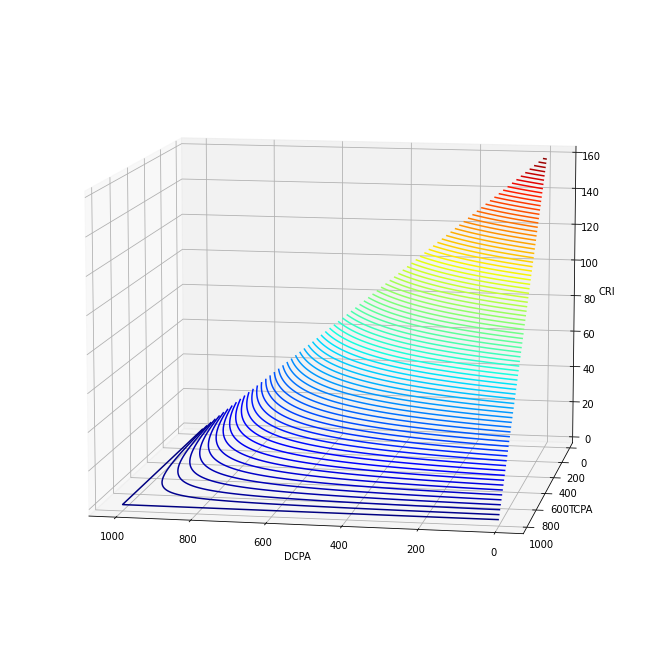

In [99]:
# CRI value depending on DCPA and TCPA
d_list = np.linspace(0, 1000, 1000) 
t_list = np.linspace(0, 1000, 1000)

d_list_ = d_list[:, np.newaxis]
t_list_ = t_list[np.newaxis, :]


# Defining CRI function of DCPA and TCPA
def cri(dcpa, tcpa):
    # Collision Risk Index (CRI)
    cons_d = 0.8
    cons_t = 0.2
    d_safe = 1000
    t_safe = 1000
    cri = 0.001 * (cons_d * (d_safe - dcpa) * cons_t * (t_safe - tcpa))
    return cri

# Calculating CRI values for DCPA and TCPA combinations
for dcpa, tcpa in zip(d_list, t_list):
    cri(dcpa, tcpa)



# Visualization 2D
plt.figure(figsize=(9,7))
plt.contourf(d_list, t_list, cri_vals.T, cmap="jet", alpha=0.7)
plt.xlabel("DCPA")
plt.ylabel("TCPA")
# color bar for CRI
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('CRI', rotation=0)
plt.show()
    
    
# Visualization 3D
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.view_init(10, 100)

dcpa, tcpa = np.meshgrid(d_list, t_list)
cri_vals = cri(dcpa, tcpa)
ax.contour3D(dcpa, tcpa, cri_vals, 100, cmap="jet")

ax.set_xlabel('DCPA')
ax.set_ylabel('TCPA')
ax.set_zlabel('CRI')
plt.show()

## Reference
Xie, Shuo, et al. "A composite learning method for multi-ship collision avoidance based on reinforcement learning and inverse control." Neurocomputing 411 (2020): 375-392.

Contour map: https://stackoverflow.com/questions/52067700/plotting-x-and-y-values-with-result-as-color-heatmap

3D Visualization: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html